In [ ]:
import time
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import json
import ast
import scipy.stats as stats

In [ ]:
test = pd.read_csv('./pre_processed.csv')

In [ ]:
test.shape

In [ ]:
def load_df(csv_path, nrows = None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     #converters are dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     #json.loads() method can be used to parse a valid JSON string and convert it into a Python Dictionary.
                     #It is mainly used for deserializing native string, byte, or byte array which consists of JSON data into Python Dictionary.
                     converters = {col: json.loads for col in json_cols},                                                                         
                         dtype = {'fullVisitorId': 'str'}, # Important!!
                         nrows = nrows)
    for col in json_cols:
        # for each column, flatten data frame such that the values of a single col are spread in different cols
        # This will use subcol as names of flat_col.columns
        flat_col = json_normalize(df[col])
        # Name the columns in this flatten data frame as col.subcol for tracability
        flat_col.columns = [f"{col}.{subcol}" for subcol in flat_col.columns]
        # Drop the json_col and instead add the new flat_col
        df = df.drop(col, axis = 1).merge(flat_col, right_index = True, left_index = True)
    return df


csv_test_path = './test_v2.csv'
test = load_df(csv_test_path, nrows = None)


In [65]:
test.shape

(401589, 60)

In [66]:
# Identify non opearting countries 
lowCountries=[]
hitWithCountry = {}
sum = 0
cnt = test['geoNetwork.country'].value_counts(sort=True)
print(cnt)
for i in range(0, cnt.size):
    sum = sum + cnt[i]

#Identify the Non Operating Countries

for i in range(0, cnt.size):
    #print(f"Country Name: {cnt.index[i]} Frequency: {(cnt[i]/sum)*100}%" )
    if((cnt[i]/sum)*100 < 0.01):
        lowCountries.append(cnt.index[i]) 
len(lowCountries)

United States            180794
India                     28900
United Kingdom            18375
Canada                    12985
Japan                     10787
                          ...  
French Guiana                 1
Cape Verde                    1
Caribbean Netherlands         1
St. Barthélemy                1
Norfolk Island                1
Name: geoNetwork.country, Length: 208, dtype: int64


80

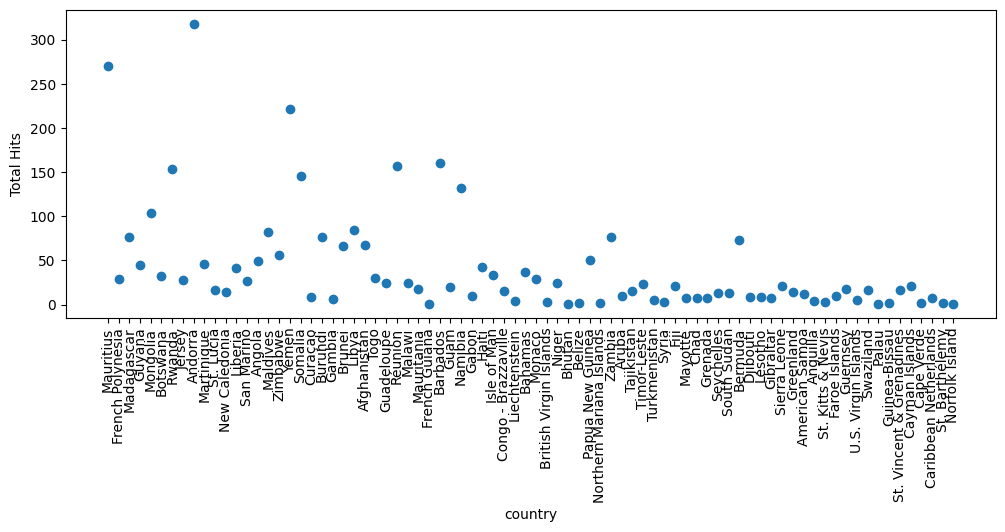

In [67]:
#Data Exploration for Rule 1
#categories = df['Predictions'].to_numpy()
colormap = np.array(['g', 'r'])
hits1 = {}
test['totals.hits'] = pd.to_numeric(test['totals.hits'])
for indx in range(test.index.start, test.index.stop):
    #print(indx)
    country = test.at[indx, 'geoNetwork.country']
    oneIndex = (test.at[indx,'hits'])
    #hitsInfo = ast.literal_eval(oneIndex)
    #print(hitsInfo)
    if country in lowCountries:
        if country not in hits1.keys():
            hits1[country] = (test.at[indx, 'totals.hits'])
        elif country in hits1.keys():
            hits1[country] = hits1[country] + (test.at[indx, 'totals.hits'])
len(hits1)
f = plt.figure(figsize=(12, 4))
f = plt.scatter(hits1.keys(), hits1.values())
f = plt.xlabel('country')
f = plt.ylabel('Total Hits')
f = plt.xticks(rotation=90)
plt.show()

In [68]:
##First Rule : If total hits of a session from NON Opearting/rare countries is outlier means 1.5 IQR from Q3
cnt=0
sum=0
lowCountries=[]
hitWithCountry = {}
cnt = test['geoNetwork.country'].value_counts(sort=True)

for i in range(0, cnt.size):
    sum = sum + cnt[i]

#Identify the Non Operating Countries

for i in range(0, cnt.size):
    #print(f"Country Name: {cnt.index[i]} Frequency: {(cnt[i]/sum)*100}%" )
    if((cnt[i]/sum)*100 < 0.01):
        lowCountries.append(cnt.index[i]) 
    

inputCountries = test.at[0,'geoNetwork.country']

test['totals.hits'] = pd.to_numeric(test['totals.hits'])
data = test['totals.hits']
np.median(data)
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
#print(upper_whisker)

for indx in range(test.index.start, test.index.stop):
    #print(indx)
    country = test.at[indx, 'geoNetwork.country']
    oneIndex = (test.at[indx,'hits'])
    #hitsInfo = ast.literal_eval(oneIndex)
    #print(hitsInfo)
    if country in lowCountries:
        hit = test.at[indx, 'totals.hits']
        if int(hit) > upper_whisker:
            test.loc[indx, 'isAnomaly'] = 1
#            print(f"Index Number : {indx} Anomalous traffic Info: {country} Total Hits : {int(hit)} Visit Date:{test.at[indx, 'date']}")
#             for ind in range(0, len(hitsInfo)):
#                 print(f"Hit Number: {hitsInfo[ind]['hitNumber']} Visited Page: {hitsInfo[ind]['appInfo']['screenName']} Keyword: {test.at[indx, 'trafficSource.keyword']}")
        #print(f"Country Name: {country} --> Total hits: {hit}")
#         if country in hitWithCountry.keys():
#             hitWithCountry[country] += 1
#         else:
#             hitWithCountry[country]=1

#newArr = test['hits'].to_numpy()


In [69]:
oneIndex = (test.at[0,'hits'])
result = ast.literal_eval(oneIndex)
#print(type(result))
for ind in range(0, len(result)):
#     temp = ast.literal_eval(oneIndex)
#     print(f"{temp}")
    print(f"Hit Number: {result[ind]['page']['pageTitle']} Visited Page: {result[ind]['appInfo']['screenName']}")

Hit Number: Kids' Apparel | Google Merchandise Store Visited Page: shop.googlemerchandisestore.com/google+redesign/apparel/kids
Hit Number: Men's Apparel | Google Merchandise Store Visited Page: shop.googlemerchandisestore.com/google+redesign/apparel/mens
Hit Number: Shopping Cart Visited Page: shop.googlemerchandisestore.com/basket.html
Hit Number: The Google Merchandise Store - Log In Visited Page: shop.googlemerchandisestore.com/signin.html
Hit Number: Shopping Cart Visited Page: shop.googlemerchandisestore.com/basket.html
Hit Number: Home Visited Page: shop.googlemerchandisestore.com/home
Hit Number: Bags | Google Merchandise Store Visited Page: shop.googlemerchandisestore.com/google+redesign/bags
Hit Number: Men's Apparel | Google Merchandise Store Visited Page: shop.googlemerchandisestore.com/google+redesign/apparel/mens
Hit Number: Women's Apparel | Google Merchandise Store Visited Page: shop.googlemerchandisestore.com/google+redesign/apparel/womens
Hit Number: Kids' Apparel | G

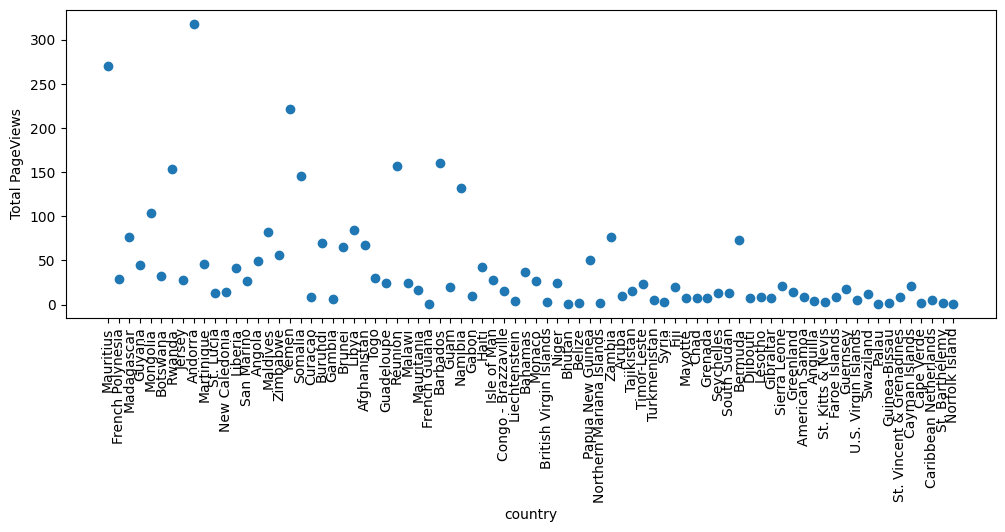

In [70]:
#Data Exploration for Rule 2
#categories = df['Predictions'].to_numpy()
colormap = np.array(['g', 'r'])
views1 = {}
test['totals.pageviews'] = pd.to_numeric(test['totals.pageviews'])
for indx in range(test.index.start, test.index.stop):
    #print(indx)
    country = test.at[indx, 'geoNetwork.country']
    #oneIndex = (test.at[indx,'totals.pageviews'])
    #hitsInfo = ast.literal_eval(oneIndex)
    #print(hitsInfo)
    if country in lowCountries:
        if country not in views1.keys():
            views1[country] = (test.at[indx, 'totals.pageviews'])
        elif country in views1.keys():
            views1[country] = views1[country] + (test.at[indx, 'totals.hits'])
len(views1)
f = plt.figure(figsize=(12, 4))
f = plt.scatter(views1.keys(), views1.values())
f = plt.xlabel('country')
f = plt.ylabel('Total PageViews')
f = plt.xticks(rotation=90)
plt.show()

In [71]:
##Rule 2 : if total pageViews from a session is absurdly higher from RareCountries
sum = 0
test['totals.pageviews'] = pd.to_numeric(test['totals.pageviews'])
##Replace NaN Values with Zero
test['totals.pageviews'].fillna(value = 0, inplace = True)
data = test['totals.pageviews']
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
lower_whisker

## Rule based on the Total PageView
for ind in range(len(test)):
    pageView = test.at[ind , 'totals.pageviews']
    country = test.at[ind , 'geoNetwork.country']
    if pageView > upper_whisker and country in lowCountries:
        test.loc[i, 'isAnomaly'] = 1

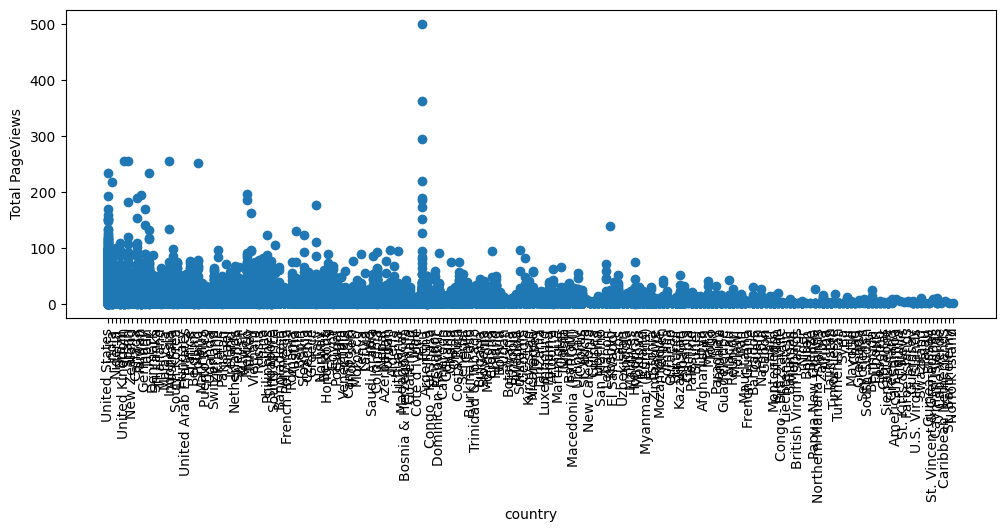

In [72]:
#Data Exploration for Rule 3
#categories = df['Predictions'].to_numpy()
colormap = np.array(['g', 'r'])

f = plt.figure(figsize=(12, 4))
f = plt.scatter(test['geoNetwork.country'], test['totals.pageviews'])
f = plt.xlabel('country')
f = plt.ylabel('Total PageViews')
f = plt.xticks(rotation=90)
plt.show()

In [73]:
##Rule 3 : if total pageViews from a session is absurdly higher from any Country
sum = 0

data = test['totals.pageviews']
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
lower_whisker

## Rule based on the Total PageView
for i in range(len(test)):
    pageView = test.loc[i , 'totals.pageviews']
    country = test.loc[i , 'geoNetwork.country']
    if pageView > upper_whisker*10:
        test.loc[i, 'isAnomaly'] = 1

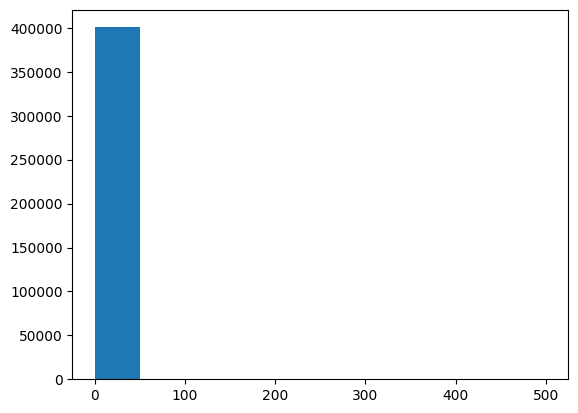

In [74]:
data = test['totals.pageviews']
plt.hist(data)
plt.show()

In [75]:
for i,j in zip(test.fullVisitorId.duplicated().index, test.fullVisitorId.duplicated()):
    if j == True:
        print(test.loc[i, 'fullVisitorId'])

39348169172379133
9737747481331319779
7107331032147848116
8191343607678235525
8788924803599914920
9737747481331319779
39348169172379133
8267617665499717437
4284689773020308062
8282107923210145980
0832323111640201979
1749098001335802050
6372044313284714275
3013619264557652981
7398112424407335214
4476633969439825599
5660841364896933762
6754604846916126619
6754604846916126619
8424253656260137080
356385607365574208
7673863569869464275
6746892019732965962
7767922669578258832
1872174021102789075
8424253656260137080
1394534604449746007
3677310886372499298
0065387621712332578
9620911006417220001
6514689657875272481
5214866598864697383
4761732960715628596
8936313174115699710
1062841436131765529
3957703859196833627
3957703859196833627
9836918269233237546
5264368356006769755
0487943184193303238
9068403172673084431
1613507840726724933
5516694761490064494
0679067438236936935
3914358559315261273
8065395739408320889
0555272800977868334
3605936638442855800
5468859209877237635
9068403172673084431
00306

0239257595272075792
7584408052106821232
7482871339636501627
3522969265598827945
9989591603954955863
0313458592418540001
2029514824964746229
0720715013977629990
362001623680912803
8961487793033139776
8915657152932339139
4432805253294447948
7126724122662648844
2704224637760505849
1898884791192616783
6845987287284537882
2704224637760505849
385290985891021525
5257145623114667841
2833912918258772770
4642359325710963873
1622475303235622210
2040261689957256375
7527468437530984107
195837480024032080
2415496210677013980
7763392413734641537
0739194709698448580
9630608005520923269
9989591603954955863
6328225403059210916
5452047453731002276
0537797558350757019
0368178843592489054
0314332543074542265
262540507569847893
3650591100765492092
7357608670273657089
083421455434086368
2029514824964746229
5874258877864279472
0386704639416953426
805195217347823778
6153213089735318868
3896975139659211395
1898884791192616783
3533044071049653256
1775066512599044443
7212222996503077587
5371979911760073873
158350

885149294195204421
573416755985914090
2033209916826725472
3949358236544700060
7552035002489149050
3045615263772098854
0373292723711857659
7567744267703746083
051066267882308671
9275909566852231336
8404534056730618510
2656110189744921275
5235304559869252922
6578506213517050394
3118268490067821729
9699539669543971670
5429318650105129931
6664813735831590283
6889311782396648996
3319280144736475309
5578675577592987066
4595154800092823633
4644440482967532889
3519704057257401807
885149294195204421
1675249305993684042
2656110189744921275
9907519190729906496
4043399323644984862
4251560324335857852
051674005488412610
6224003373490691280
0767060715885239142
4323489846975838097
0156528615630727095
1746064936357070831
1617547108870132312
9057713503019233930
0373292723711857659
7444440902367565919
9992352575558115531
0877459979544488705
7094509197336799400
6306789185594341238
0650107116874202739
9634707040965068344
5512705803298374229
9940804516778622825
9230519490539769555
203450851119695542
449780

8071181826444687757
8011909907994661956
3469156538581158922
7751880730563433579
4415845515081164385
0818610479374509910
3718586778490604321
8649867307625943431
6795080487697508735
7942090340558661368
8670167594673893470
4705710013854025893
6303255431791084723
3613899418139986418
6166297399019779312
4367840979398233943
5038140152048924809
9720452040268136432
4600242336225959034
6241554015509806534
9265482117721559243
7282998257608986241
590726145052593645
4850985669144708304
9770044181996843122
1974815581044113366
3898195248702687111
5775081527368418126
0728138935514819332
6900709740300587937
3376149420053703979
3742461312787413597
8364839672755619327
3183672120875701817
0611003557850290415
8364839672755619327
7800289446092243098
4262254905261840590
4053453388279139407
383908713924440347
383908713924440347
0436498327249062861
6900709740300587937
1917234667102461347
1917234667102461347
2951619319766366712
1750340680965146676
2042982149827911886
3785354133211384616
8364898215258197427
194

7174919121451025011
9927381474692400337
6115981048716072830
1307890244087238442
8281789761646014256
1381855168653383440
0560000615960037597
2152415090112593728
9278242064166884918
6160310381252227422
1719337716276701512
7080385631328802115
0287032412573593978
3084081822239855325
7136771447686764330
9014351031492026068
4802830281959891446
1112508271009760881
4966306927144254583
8427071439989356831
281325861587705205
9451629994264060401
0522494579515321362
2167167497411094144
7960178291068208469
1018069719956755271
6608150312795515090
6833912159350638505
5577491464498299981
7471461821730316137
3689591256160417475
1112508271009760881
9725311525711732422
42087442309142584
0214215482924529818
4092958459755636877
692417475944128141
9707784141325047853
2454652104756512233
3908026702209981358
4910058057612671722
9522944384650111883
6833912159350638505
1811165171733672047
0169859039371140479
6624663126185858318
4546658372203324837
3908471808813580118
5123963772701161900
5401531323064643738
2153

6937464801764989850
1974366891841392314
0794822821776525869
9078579808171746202
7587945686589328420
9514749677791546367
4249617746603834038
8583806070090030292
6016714305583610425
2294718271365100100
2232415829661903407
0440691579874636033
813950427409191193
6874278542736524025
368017382816974049
5678400043144195246
4036545174593965167
5471495037483420143
9160187923406524652
0482859657803174749
463765343124762430
5341758595007739908
5121453966155985426
3960989387371756288
2303584398069102356
9712575408710535006
3843820073045443103
291084852095568092
0394668972595659628
9664726459995494056
2701479707024176758
898935807632285684
5125630447564226504
689242140958484744
8890418520221974887
8583115159538248435
6915968810892726813
4345885179167275527
4652651440185097685
6937464801764989850
6714534128082027149
5395786390139906518
9664726459995494056
5762901251218277455
1279519953146388578
9055369453704834493
5312687939203683382
6323294520398688511
6821513254326947480
7497063696374825925
169976

In [76]:
sum = 0
test['totals.hits'] = pd.to_numeric(test['totals.hits'])
mean = test['totals.hits'].mean()
std = test['totals.hits'].std()
maximum = test['totals.hits'].max()

#plt.boxplot(test['totals.hits'])
#plt.xlim(xmin=0, xmax = 501)
#plt.show()
data = test['totals.hits']
np.median(data)
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
upper_whisker
data    

0         10
1          1
2          1
3         53
4          1
          ..
401584     5
401585     7
401586     5
401587     6
401588     1
Name: totals.hits, Length: 401589, dtype: int64

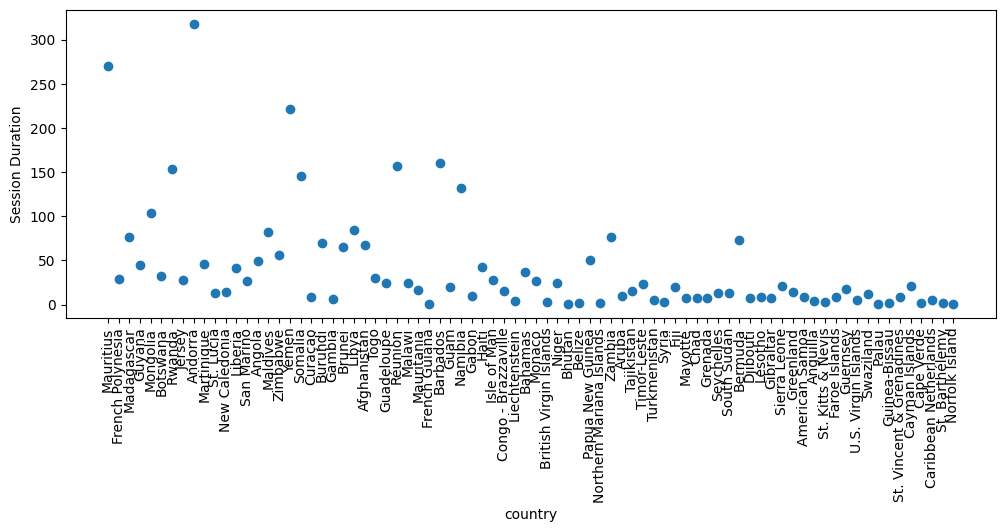

In [77]:
#Data Exploration for Rule 4
#categories = df['Predictions'].to_numpy()
colormap = np.array(['g', 'r'])
tos1 = {}
test['totals.timeOnSite'] = pd.to_numeric(test['totals.timeOnSite'])
for indx in range(test.index.start, test.index.stop):
    #print(indx)
    country = test.at[indx, 'geoNetwork.country']
    #oneIndex = (test.at[indx,'totals.pageviews'])
    #hitsInfo = ast.literal_eval(oneIndex)
    #print(hitsInfo)
    if country in lowCountries:
        if country not in tos1.keys():
            tos1[country] = (test.at[indx, 'totals.pageviews'])
        elif country in tos1.keys():
            tos1[country] = tos1[country] + (test.at[indx, 'totals.hits'])
len(tos1)
f = plt.figure(figsize=(12, 4))
f = plt.scatter(tos1.keys(), tos1.values())
f = plt.xlabel('country')
f = plt.ylabel('Session Duration')
f = plt.xticks(rotation=90)
plt.show()

In [78]:
# Rule 4: Session duration is outlier for non operating countries
## total.timeOnSite means session duration of a session
sum = 0
test['totals.timeOnSite'] = pd.to_numeric(test['totals.timeOnSite'])
test['totals.timeOnSite'].fillna(value = 0, inplace = True)
data = test['totals.timeOnSite']
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
for i in range(len(test)):
    timeOnSite = test.at[i, 'totals.timeOnSite']
    country = test.at[i, 'geoNetwork.country']
    if timeOnSite > upper_whisker and country in lowCountries:
        test.loc[i, 'isAnomaly'] = 1


In [79]:
# Determining how many users come to our system in an hour to create a baseline for rule 5
#test['visitStartTime'] = pd.to_datetime(test['visitStartTime'], unit='s')
usersWithDate = {}
test['date'] = pd.to_numeric(test['date'])
test = test.sort_values(by = 'visitStartTime')
test = test.reset_index(drop = True)
#print(test)
timeDiff = test['visitStartTime'].max() - test['visitStartTime'].min()
dayDiff = timeDiff / 86400
dayDiff = dayDiff.round()
print(dayDiff)
UsersPerDay = (test['fullVisitorId'].count() / dayDiff).round()
UsersPerHour = (UsersPerDay/24).round()
hourCount = 86400/24
startTime = test.loc[0 , 'visitStartTime']
sumOfUsers = 0
userCounts=[]
for itr in range(len(test)):
    #print(test.loc[itr, 'visitStartTime'])
    if(test.loc[itr, 'visitStartTime'] > (startTime + 3600)):
        startTime = test.loc[itr, 'visitStartTime']
        usersWithDate[startTime] = sumOfUsers
        userCounts.append(sumOfUsers)
        sumOfUsers = 0
    sumOfUsers = sumOfUsers+1
len(userCounts)
#test.head()

168.0


3984

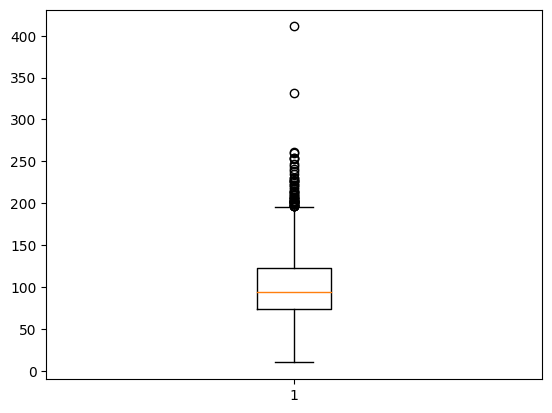

In [80]:
a = np.array(userCounts)
plt.boxplot(a)
plt.show()

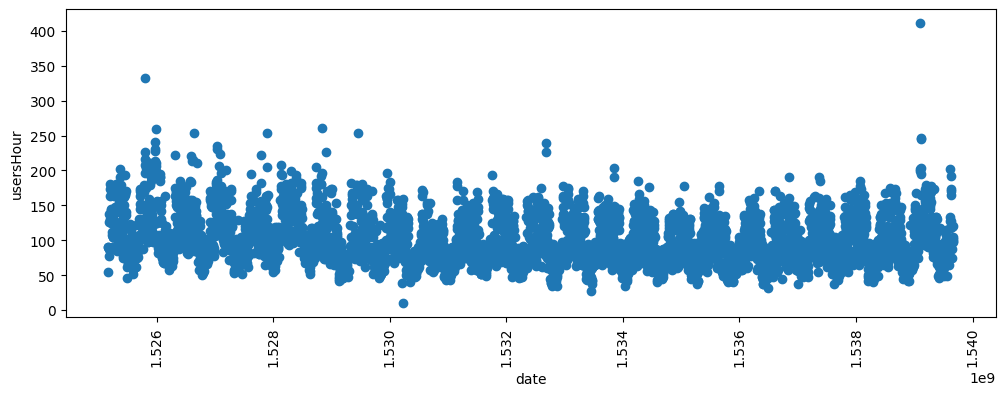

In [81]:
#categories = df['Predictions'].to_numpy()
colormap = np.array(['g', 'r'])

f = plt.figure(figsize=(12, 4))
f = plt.scatter(usersWithDate.keys(), usersWithDate.values())
f = plt.xlabel('date')
f = plt.ylabel('usersHour')
f = plt.xticks(rotation=90)
plt.show()

In [82]:
# rule 5 : Detect Anomalous users generating higher volume of traffic in an hour
sum = 0
anomalousHours = []
times = {}
data = list(usersWithDate.values())
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = upper_q+1.5*iqr
lower_whisker = lower_q-1.5*iqr
for i,j in usersWithDate.items():
    if j > upper_whisker:
        anomalousHours.append(i)

for i in range(len(anomalousHours)):
    for j in range(len(test)):
        endTime = anomalousHours[i]
        startTime = endTime - 3600
        if test.loc[j, 'visitStartTime'] >=startTime and test.loc[j, 'visitStartTime'] <= endTime:
            if j not in times:
                times[j] = (test.loc[j, 'totals.hits'])
            elif j not in times:
                times[j] = times[j] + (test.loc[j, 'totals.hits'])
    data = list(times.values())
    upper_q = np.percentile(data, 75)
    lower_q = np.percentile(data, 25)
    iqr = upper_q - lower_q
    upper_whisker = upper_q+1.5*iqr
    lower_whisker = lower_q-1.5*iqr
#     print(upper_whisker)
    for a, b in times.items():
        if b > upper_whisker:
            test.loc[a, 'isAnomaly'] = 1

In [86]:
test['isAnomaly'].fillna(value = 0, inplace = True)
aomalousSessions = test[test['isAnomaly'] == 1]
len(aomalousSessions)

1396

In [84]:
aomalousSessions.to_csv('./out.csv')  

In [85]:
kw = test[test['trafficSource.keyword'] != '(not set)']
kw = kw[kw['trafficSource.keyword'] != 'NaN']
kw = kw[kw['trafficSource.keyword'] != '(not provided)']
kw['hits'][0]

'[{\'hitNumber\': \'14\', \'time\': \'0\', \'hour\': \'0\', \'minute\': \'0\', \'isInteraction\': True, \'page\': {\'pagePath\': \'/google+redesign/apparel/kids\', \'hostname\': \'shop.googlemerchandisestore.com\', \'pageTitle\': "Kids\' Apparel | Google Merchandise Store", \'pagePathLevel1\': \'/google+redesign/\', \'pagePathLevel2\': \'/apparel/\', \'pagePathLevel3\': \'/kids\', \'pagePathLevel4\': \'\'}, \'transaction\': {\'currencyCode\': \'USD\'}, \'item\': {\'currencyCode\': \'USD\'}, \'appInfo\': {\'screenName\': \'shop.googlemerchandisestore.com/google+redesign/apparel/kids\', \'landingScreenName\': \'shop.googlemerchandisestore.com/google+redesign/apparel/kids\', \'exitScreenName\': \'shop.googlemerchandisestore.com/google+redesign/apparel/kids\', \'screenDepth\': \'0\'}, \'exceptionInfo\': {\'isFatal\': True}, \'eventInfo\': {\'eventCategory\': \'Enhanced Ecommerce\', \'eventAction\': \'Add to Cart\'}, \'product\': [{\'productSKU\': \'GGOEGXXX0892\', \'v2ProductName\': \'Goog